# Federated Averaging Logistic Regression

## Set up Data Federation

In [114]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import load_iris
import numpy as np
import torch

random_seed = 1
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

def get_kidney_dataframe():

    DATA_PATH = "../../sail-safe-functions-test/sail_safe_functions_test/data_sail_safe_functions"
    path_file_csv = os.path.join(DATA_PATH, "data_csv_kidney_clean", "kidney_disease_clean.csv")
    df =  pd.read_csv(path_file_csv)
    df = pd.get_dummies(data=df)

    return df

def get_test_federation_split(df):

    train = df.sample(frac=0.8)
    test = df.drop(train.index)
    
    shuffled = train.sample(frac=1)
    result = np.array_split(shuffled, 5)  

    return result, test

dataframe = get_kidney_dataframe()

data_federation, test = get_test_federation_split(dataframe)

## Run Federated Averaging

In [115]:
from sail_safe_functions_orchestrator.machine_learning.federated_averaging import federated_averaging
from helper_libs.shared.models.LogisticRegression import LogisticRegression

X_col = ['age', 'bp', 'sg', 'al']
Y_col = ['classification_ckd']
in_layer = len(X_col)
out_layer = len(Y_col)
optimizer = "SGD"
criterion = "BCELoss"
starting_model = LogisticRegression(in_layer, out_layer)
learn_rate = 0.001
epochs=2500
federal_epochs=4

model = federated_averaging(epochs, federal_epochs, data_federation, X_col, Y_col, learn_rate, starting_model, criterion, optimizer)

### Compare Random and Trained Models

/tmp/ipykernel_10259/2594879964.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  plt.plot(column_a, predictions, 'go', label='Predictions', color="red", alpha=0.2)


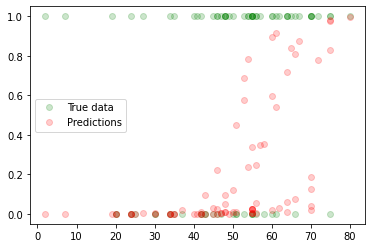

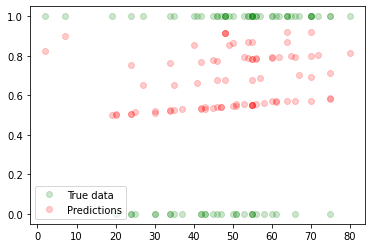

In [116]:
import torch
import matplotlib.pyplot as plt

def print_graph(predicted, x_train, y_train):

    predictions = predicted
    labels = y_train


    column_a = []
    for x in x_train:
        column_a.append(x[0])

    plt.plot(column_a, labels, 'go', label='True data', alpha=0.2)
    plt.plot(column_a, predictions, 'go', label='Predictions', color="red", alpha=0.2)
    plt.legend(loc='best')
    plt.show()

X_test = torch.Tensor(test[X_col].values).float()
Y_test = torch.Tensor(test[Y_col].values).float()


predicted = starting_model(X_test).detach().numpy()
print_graph(predicted, X_test, Y_test)

predicted = model(X_test).detach().numpy()
print_graph(predicted, X_test, Y_test)

In [117]:
from sklearn.metrics import precision_score, recall_score, f1_score

def score_model(predicted, Y_test):
    predictions = predicted

    labels = Y_test

    precision = precision_score(predictions, labels, average="weighted")
    recall = recall_score(predictions, labels, average="weighted")
    f1 = f1_score(predictions, labels, average="weighted")

    return precision, recall, f1

In [118]:
#Binarize continuous classifications
predictions = []
for prediction in predicted: 
    if prediction > 0.5:
        predictions.append(1)
    else:
        predictions.append(0)

print(score_model(predictions, Y_test))

(1.0, 0.6125, 0.7596899224806202)


/mnt/c/Users/AdamHall/Documents/GitHub/datascience/venv38_sail/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
